# Power spectal density analysis using full frame data
* 4/12/24 setup
* 4/13/2024 single somatic dataset

In [12]:
from os.path import join, dirname
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
import pandas as pd
import seaborn as sns

# from ydata_profiling import ProfileReport
# from src import eeg_class as ec
from src import full_frame_analysis as ffa

# from src.classes import database
from src import full_frame_analysis as ffa
from src.classes.imaging_data_class import ImagingData
from src.clustering import interval_length_calculator as ilc
from src.clustering import process_dfof_intervals as pdi

import plotly.graph_objects as go


def open_and_convert(sima_path):
    raw_ff_data = pd.read_csv(
        join(sima_path, "s2p_ff/suite2p/plane0/reg_tif/ff_data.csv")
    )
    return raw_ff_data.convert_dtypes()

In [2]:
# db = database.ExperimentDatabase()
# dendritic_trials = [927, 935, 934, 929, 936, 931, 937, 932]
# somatic_trials = [745, 740, 749, 762, 761, 760, 885, 890]

In [3]:
mice = ["5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"]

In [4]:
mouse = ImagingData(mice[4])
mouse.mouse_id
s2p_folders = mouse.find_s2p_folders()
for folder in enumerate(s2p_folders):
    print(folder)

Looking for Suite2p folders in /data2/gergely/invivo_DATA/sleep/sert54a_5
(0, '/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima/suite2p')
(1, '/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima/s2p_ff/suite2p')


In [5]:
s2p_folder = s2p_folders[0]
sima_folder = dirname(s2p_folder)
sima_folder

'/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima'

In [6]:
somatic = open_and_convert(sima_folder)
somatic_dfof = somatic["DeltaF_F"]

nrem_intervals = ilc(somatic, "NREM", 1)
awake_intervals = ilc(somatic, "NREM", 0)

nrem_threshold = nrem_intervals.loc[nrem_intervals["length"] < 610, "n"].values
awake_threshold = awake_intervals.loc[awake_intervals["length"] < 610, "n"].values

thresholded_nrem = (
    nrem_intervals.loc[nrem_intervals["n"].isin(nrem_threshold)]
    .reset_index(drop=True)
    .copy()
)
thresholded_awake = (
    awake_intervals.loc[awake_intervals["n"].isin(awake_threshold)]
    .reset_index(drop=True)
    .copy()
)

nrem_intervals = pdi(somatic_dfof, thresholded_nrem)
awake_intervals = pdi(somatic_dfof, thresholded_awake)
nrem_intervals.shape, awake_intervals.shape

((1, 3978), (1, 1564))

In [ ]:
# figure = plt.figure(figsize=(10, 5))
# plt.plot(somatic["DeltaF_F"][:3000])
# sns.despine()
# plt.savefig(join(sima_folder, "somatic_trace.svg"))
# plt.show()

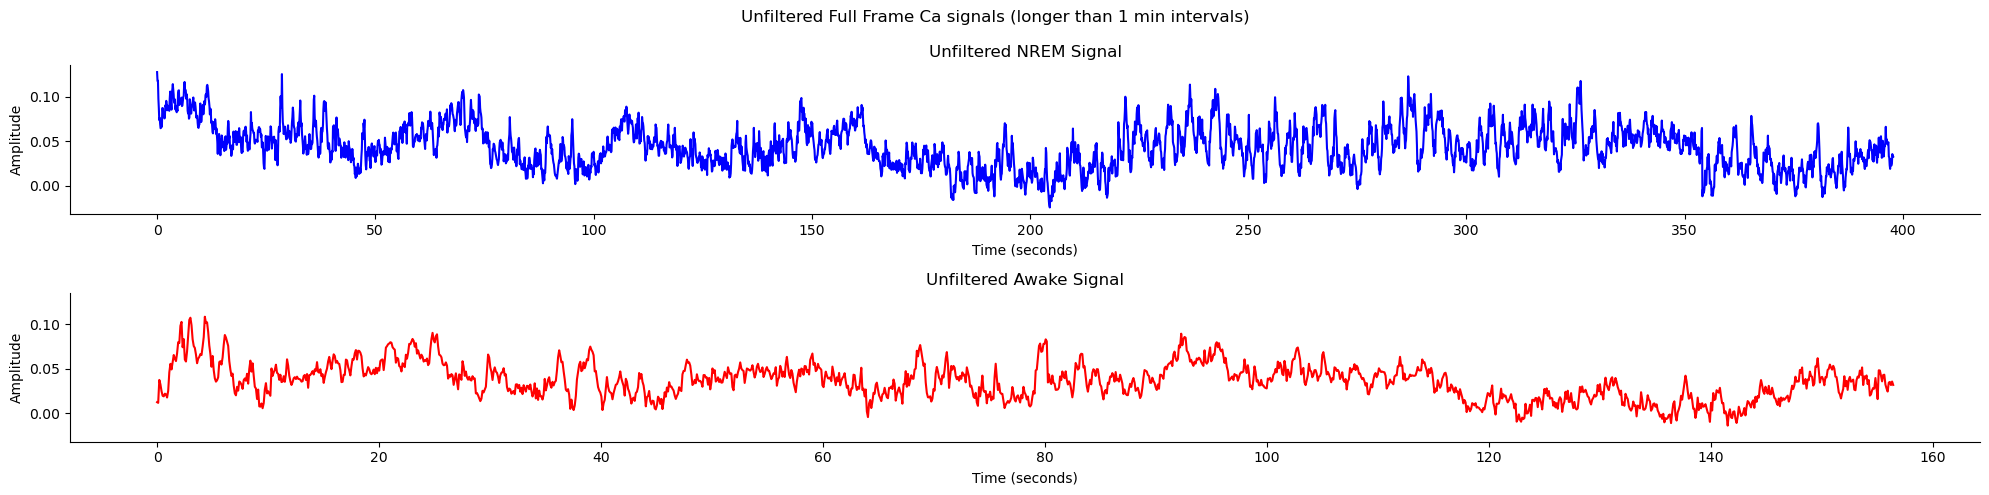

In [26]:
raw_nrem = pd.Series(nrem_intervals.iloc[0].values)
raw_awake = pd.Series(awake_intervals.iloc[0].values)

# Calculate the time vector for the x-axis (in seconds)
nrem_time = np.linspace(0, len(raw_nrem) / 10, num=len(raw_nrem))
awake_time = np.linspace(0, len(raw_awake) / 10, num=len(raw_awake))

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), sharey=True)
fig.suptitle("Unfiltered Full Frame Ca signals (longer than 1 min intervals)")

# Plot the filtered NREM data with time on the x-axis
ax[0].plot(nrem_time, raw_nrem, color="blue")
ax[0].set_title("Unfiltered NREM Signal")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Amplitude")

# Plot the filtered Awake data with time on the x-axis
ax[1].plot(awake_time, raw_awake, color="red")
ax[1].set_title("Unfiltered Awake Signal")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Amplitude")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
sns.despine()
fig.savefig(join(sima_folder, "Unfiltered ff signals.png"), dpi=300)
plt.show()

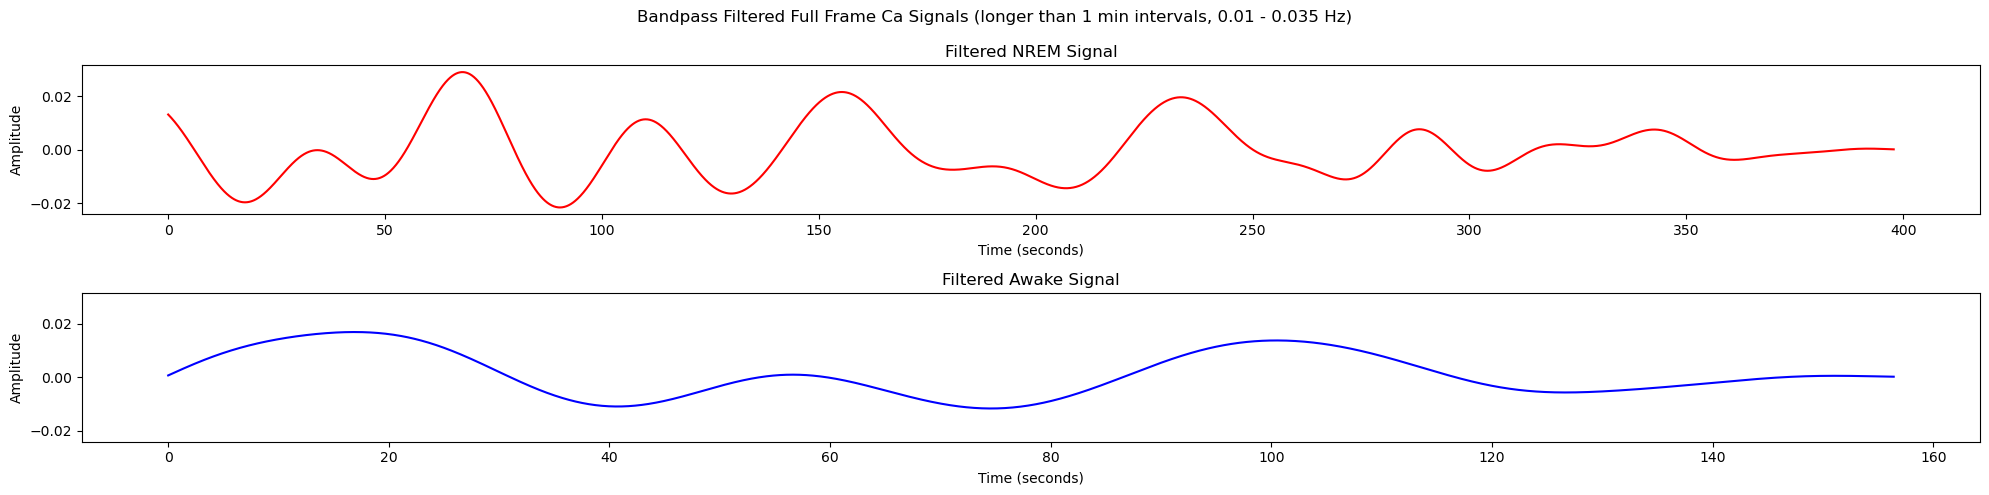

In [19]:
filt_nrem = ffa.bandpass_filter_with_padding(raw_nrem, 0.01, 0.035, 10)
filt_awake = ffa.bandpass_filter_with_padding(raw_awake, 0.01, 0.035, 10)

# Calculate the time vector for the x-axis (in seconds)
nrem_time = np.linspace(0, len(filt_nrem) / 10, num=len(filt_nrem))
awake_time = np.linspace(0, len(filt_awake) / 10, num=len(filt_awake))

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), sharey=True)
fig.suptitle(
    "Bandpass Filtered Full Frame Ca Signals (longer than 1 min intervals, 0.01 - 0.035 Hz)"
)

# Plot the filtered NREM data with time on the x-axis
ax[0].plot(nrem_time, filt_nrem, color="red")
ax[0].set_title("Filtered NREM Signal")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Amplitude")

# Plot the filtered Awake data with time on the x-axis
ax[1].plot(awake_time, filt_awake, color="blue")
ax[1].set_title("Filtered Awake Signal")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Amplitude")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(join(sima_folder, "Bandpass ff signals.png"), dpi=300)
plt.show()

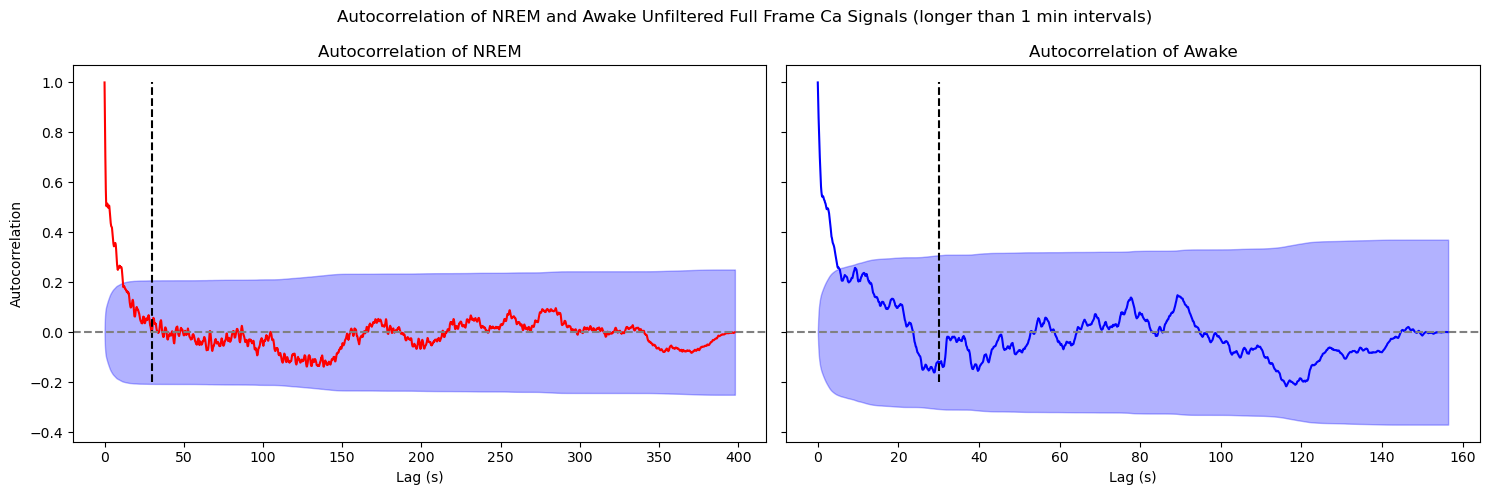

In [20]:
acf_nrem, ci_nrem = ffa.autocorrelation(raw_nrem)
acf_nrem_time = np.linspace(0, len(acf_nrem) / 10, num=len(acf_nrem))
acf_awake, ci_awake = ffa.autocorrelation(raw_awake)
acf_awake_time = np.linspace(0, len(acf_awake) / 10, num=len(acf_awake))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
fig.suptitle(
    "Autocorrelation of NREM and Awake Unfiltered Full Frame Ca Signals (longer than 1 min intervals)"
)

# Plot autocorrelation for raw_nrem
ax[0].plot(acf_nrem_time, acf_nrem, color="red")
ax[0].set_title("Autocorrelation of NREM")
ax[0].set_xlabel("Lag (s)")
ax[0].set_ylabel("Autocorrelation")
ax[0].fill_between(
    acf_nrem_time,
    ci_nrem[:, 0] - acf_nrem,
    ci_nrem[:, 1] - acf_nrem,
    color="blue",
    alpha=0.3,
)
ax[0].vlines(30, -0.2, 1, color="black", linestyle="--")
ax[0].axhline(y=0, linestyle="--", color="gray")

# Plot autocorrelation for raw_awake
ax[1].plot(acf_awake_time, acf_awake, color="blue")
ax[1].set_title("Autocorrelation of Awake")
ax[1].set_xlabel("Lag (s)")
ax[1].fill_between(
    acf_awake_time,
    ci_awake[:, 0] - acf_awake,
    ci_awake[:, 1] - acf_awake,
    color="blue",
    alpha=0.3,
)
ax[1].vlines(30, -0.2, 1, color="black", linestyle="--")
ax[1].axhline(y=0, linestyle="--", color="gray")
# ax[1].set_ylabel('Autocorrelation')  # Not needed, shared y-axis

# Enhance layout
plt.tight_layout()
fig.savefig(join(sima_folder, "Autocorrelation NREM Awake ff signals.png"), dpi=300)
plt.show()

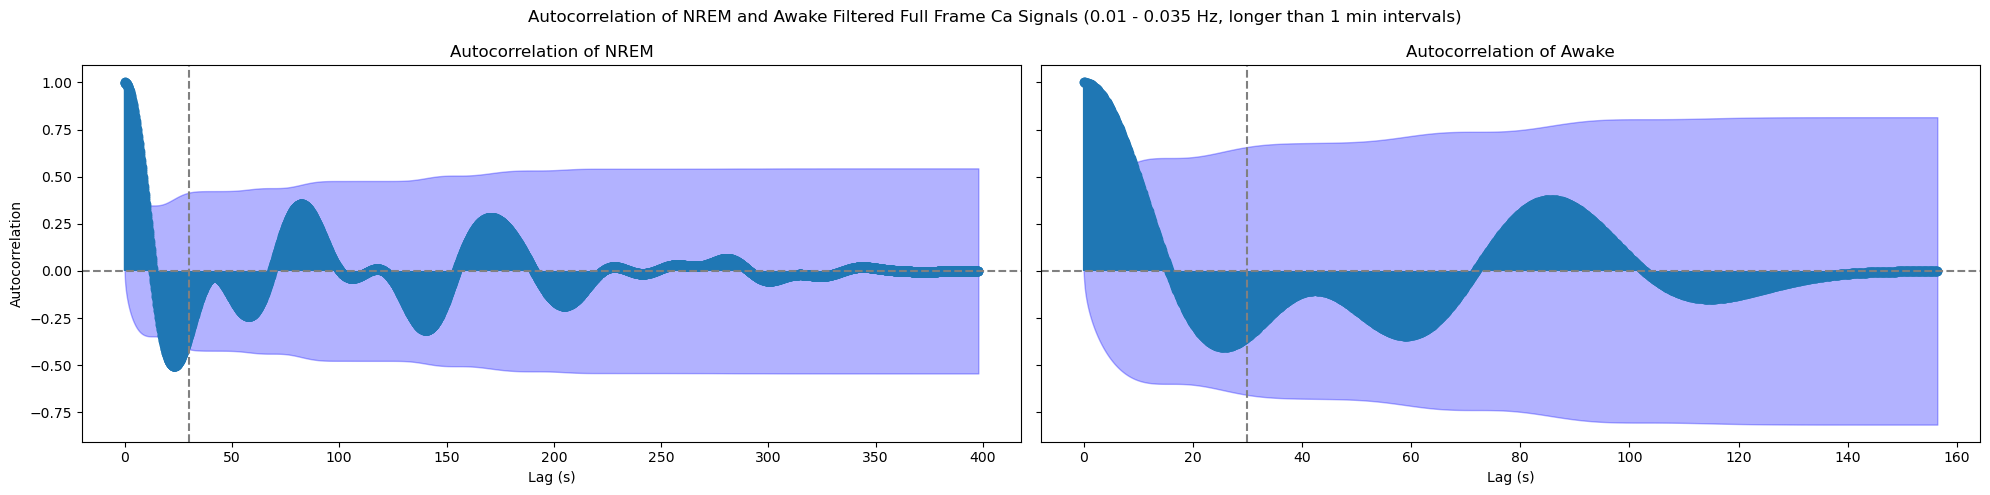

In [21]:
# filtered signals
filt_acf_nrem, filt_ci_nrem = ffa.autocorrelation(filt_nrem)
filt_acf_nrem_time = np.linspace(0, len(filt_acf_nrem) / 10, num=len(filt_acf_nrem))
filt_acf_awake, filt_ci_awake = ffa.autocorrelation(filt_awake)
filt_acf_awake_time = np.linspace(0, len(filt_acf_awake) / 10, num=len(filt_acf_awake))


# Set up the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)
fig.suptitle(
    "Autocorrelation of NREM and Awake Filtered Full Frame Ca Signals (0.01 - 0.035 Hz, longer than 1 min intervals)"
)

# Plot autocorrelation for filt_nrem
axs[0].stem(filt_acf_nrem_time, filt_acf_nrem, basefmt=" ")
axs[0].fill_between(
    filt_acf_nrem_time,
    filt_ci_nrem[:, 0] - filt_acf_nrem,
    filt_ci_nrem[:, 1] - filt_acf_nrem,
    color="blue",
    alpha=0.3,
)
axs[0].set_title("Autocorrelation of NREM")
axs[0].set_xlabel("Lag (s)")
axs[0].set_ylabel("Autocorrelation")
axs[0].axhline(y=0, linestyle="--", color="gray")
axs[0].axvline(x=30, linestyle="--", color="gray")

# Plot autocorrelation for filt_awake
axs[1].stem(filt_acf_awake_time, filt_acf_awake, basefmt=" ")
axs[1].fill_between(
    filt_acf_awake_time,
    filt_ci_awake[:, 0] - filt_acf_awake,
    filt_ci_awake[:, 1] - filt_acf_awake,
    color="blue",
    alpha=0.3,
)
axs[1].set_title("Autocorrelation of Awake")
axs[1].set_xlabel("Lag (s)")
axs[1].axhline(y=0, linestyle="--", color="gray")
axs[1].axvline(x=30, linestyle="--", color="gray")

# Enhance layout and display the plot
plt.tight_layout()
fig.savefig(
    join(sima_folder, "Autocorrelation Filtered NREM Awake ff signals.png"), dpi=300
)
plt.show()

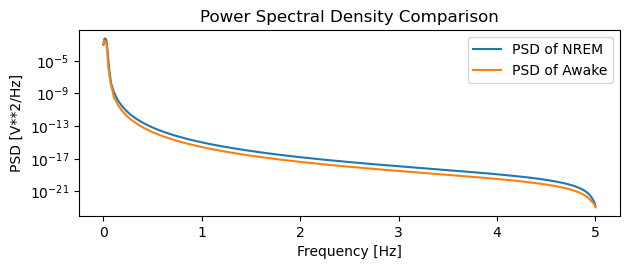

In [22]:
# Frequency Domain Analysis (Power Spectral Density)
fs = 10.0
f1, Pxx_den1 = welch(filt_nrem, fs, nperseg=1024)
f2, Pxx_den2 = welch(filt_awake, fs, nperseg=1024)
plt.subplot(2, 1, 2)
plt.semilogy(f1, Pxx_den1, label="PSD of NREM")
plt.semilogy(f2, Pxx_den2, label="PSD of Awake")
plt.title("Power Spectral Density Comparison")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.legend()
plt.tight_layout()
plt.show()

# Coherence Analysis
# f, Cxy = coherence(filt_nrem, filt_awake, fs, nperseg=1024)
# plt.figure()
# plt.plot(f, Cxy)
# plt.title("Magnitude-Squared Coherence")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Coherence")
# plt.show()

In [23]:
def plot_fft_comparison(freq1, mag1, freq2, mag2, label1="Signal 1", label2="Signal 2"):
    """
    Plot FFT magnitudes of two signals for comparison using Plotly.

    Args:
        freq1 (array): Frequencies for the first signal.
        mag1 (array): Magnitudes for the first signal.
        freq2 (array): Frequencies for the second signal.
        mag2 (array): Magnitudes for the second signal.
        label1 (str): Label for the first signal.
        label2 (str): Label for the second signal.
    """
    # Create the figure
    fig = go.Figure()

    # Add the first signal trace
    fig.add_trace(go.Scatter(x=freq1, y=mag1, mode="lines", name=label1))

    # Add the second signal trace
    fig.add_trace(go.Scatter(x=freq2, y=mag2, mode="lines", name=label2))

    # Update plot layout
    fig.update_layout(
        title="FFT Magnitude Comparison",
        xaxis_title="Frequency (Hz)",
        yaxis_title="Magnitude",
        yaxis_type="log",  # Use log scale for magnitude for better visibility
        xaxis=dict(
            range=[0, max(freq1[-1], freq2[-1])]
        ),  # Adjust x-axis to fit the data
    )

    # Show the plot
    fig.show()

In [25]:
fs = 10
t = np.linspace(0, 1, fs, endpoint=False)
nrem_signal = raw_nrem
awake_signal = raw_awake

awake_freq, awake_mag = ffa.calculate_fft(awake_signal, fs)
nrem_freq, nrem_mag = ffa.calculate_fft(nrem_signal, fs)

plot_fft_comparison(nrem_freq, nrem_mag, awake_freq, awake_mag, "NREM", "Awake")

In [36]:
def plot_frequency_components(
    freq1, psd1, freq2, psd2, title1="Signal 1", title2="Signal 2"
):
    """
    Plot the main frequency components of two signals for comparison and return the figure object.

    Args:
        freq1 (np.array): Frequencies of the first signal.
        psd1 (np.array): PSD values of the first signal.
        freq2 (np.array): Frequencies of the second signal.
        psd2 (np.array): PSD values of the second signal.
        title1 (str): Title for the first signal plot.
        title2 (str): Title for the second signal plot.
    """
    # Create a figure object with a specific size
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot for the first signal
    axs[0].stem(freq1, psd1, linefmt="b-", markerfmt="bo", basefmt="b-")
    axs[0].set_title(title1)
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Power Spectral Density")
    axs[0].set_ylim(0, 750)
    axs[0].grid(True)
    axs[0].fill_betweenx(y=[0, 2000], x1=0.01, x2=0.04, color="grey", alpha=0.3)

    # Plot for the second signal
    axs[1].stem(freq2, psd2, linefmt="r-", markerfmt="ro", basefmt="r-")
    axs[1].set_title(title2)
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Power Spectral Density")
    axs[1].set_ylim(0, 750)
    axs[1].grid(True)
    axs[1].fill_betweenx(
        y=[0, 2000],
        x1=0.01,
        x2=0.04,
        color="grey",
        alpha=0.3,
    )

    # Set the super title for the figure
    fig.suptitle("Comparison of Main Frequency Components Unfiltered FF")
    plt.tight_layout()

    # Return the figure object
    return fig

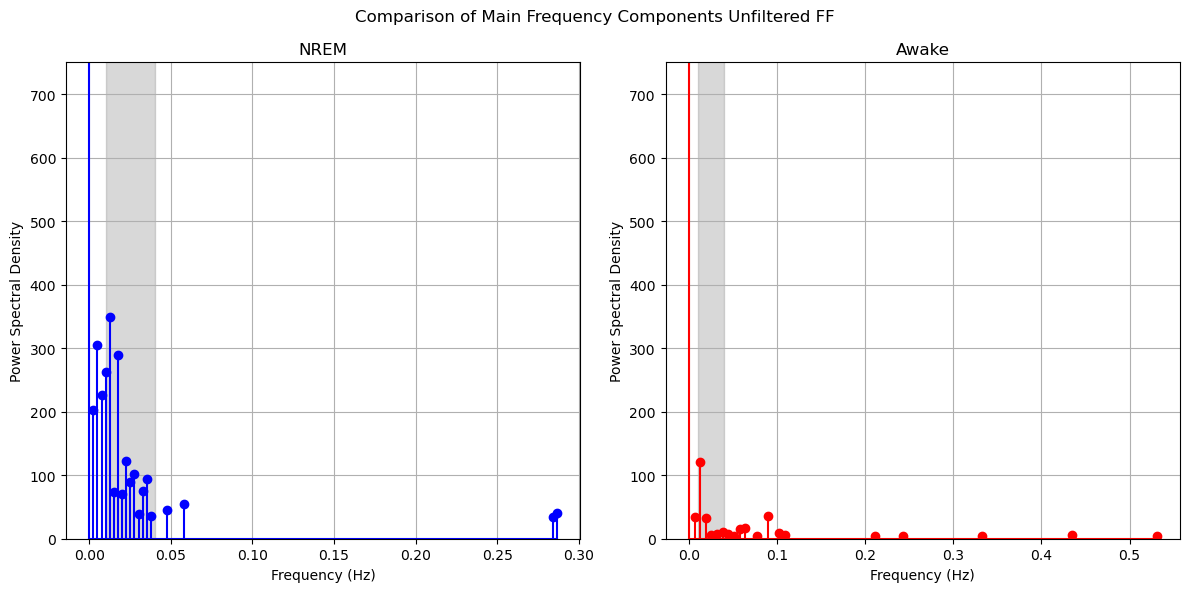

In [37]:
nrem_signal = raw_nrem
awake_signal = raw_awake
fs = 10.0

nrem_freq, nrem_psd = ffa.calculate_frequency_components(nrem_signal, fs)
awake_freq, awake_psd = ffa.calculate_frequency_components(awake_signal, fs)

fig = plot_frequency_components(
    nrem_freq, nrem_psd, awake_freq, awake_psd, "NREM", "Awake"
)
fig.savefig(join(sima_folder, "Main Frequency Components raw ff signals.png"), dpi=300)

In [186]:
nrem_mask = (nrem_freq >= 0.01) & (nrem_freq <= 0.035)
awake_mask = (awake_freq >= 0.01) & (awake_freq <= 0.035)
nrem_filt_psd = nrem_psd[nrem_mask]
awake_filt_psd = awake_psd[awake_mask]

In [187]:
data_to_save = {
    "data_dir": sima_folder,
    "nrem_filt_psd": [nrem_filt_psd],
    "awake_filt_psd": [awake_filt_psd],
}

# Save the data to a CSV file
data_df = pd.DataFrame(data_to_save)
data_df.to_csv(join(sima_folder, "psd_data.csv"), index=False)

In [188]:
data_df

,data_dir,nrem_filt_psd,awake_filt_psd
0,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4...,"[38.3685524080011, 70.12737979439183, 74.22830...","[6.096749458753332, 8.110375336935777, 33.1782..."
